# Cookie factory

You are the manager of a company which produces cookies and you want to introduce a new product. Your R\&D department has proposed and developed the following two alternatives:

1. Unicorn cookies (UC)
2. Vanilla-chip cookies (VC).

As part of your market research, you are interested in predicting whether certain customers are likely to buy one of the new products. For that, you have already collected data from a large number of test persons.
In particular, you asked them to fill out a query with the following questions:

1. *What do you think is the most fascinating: Rainbows, Black holes or Cats?* (variable $preferences$)
2. *How much money do you spend on cookies per month?* (variable $money$)
3. *Which of our cookies would you buy?* (variable $product$)  
   *Note*: The variable $product$ can also take on the value "No product" (NP).

You can find the data in *cookie-factory.csv*.

## Imports and data

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import scipy.stats as dists

In [2]:
data = pd.read_csv("cookie-factory.csv")
data.head()

# preferences: discrete {"R", "B", "C"}
# money: continuous [0, +inf]
# product: discrete {"NP", "VC", "UC"}

,product,age,preferences,money
0,Unicorn,16,Rainbows,12.65
1,No product,58,Cats,25.91
2,Vanilla,38,Cats,25.39
3,Unicorn,28,Rainbows,18.05
4,Unicorn,45,Cats,3.27


## Data visualization

Nothing to do here...

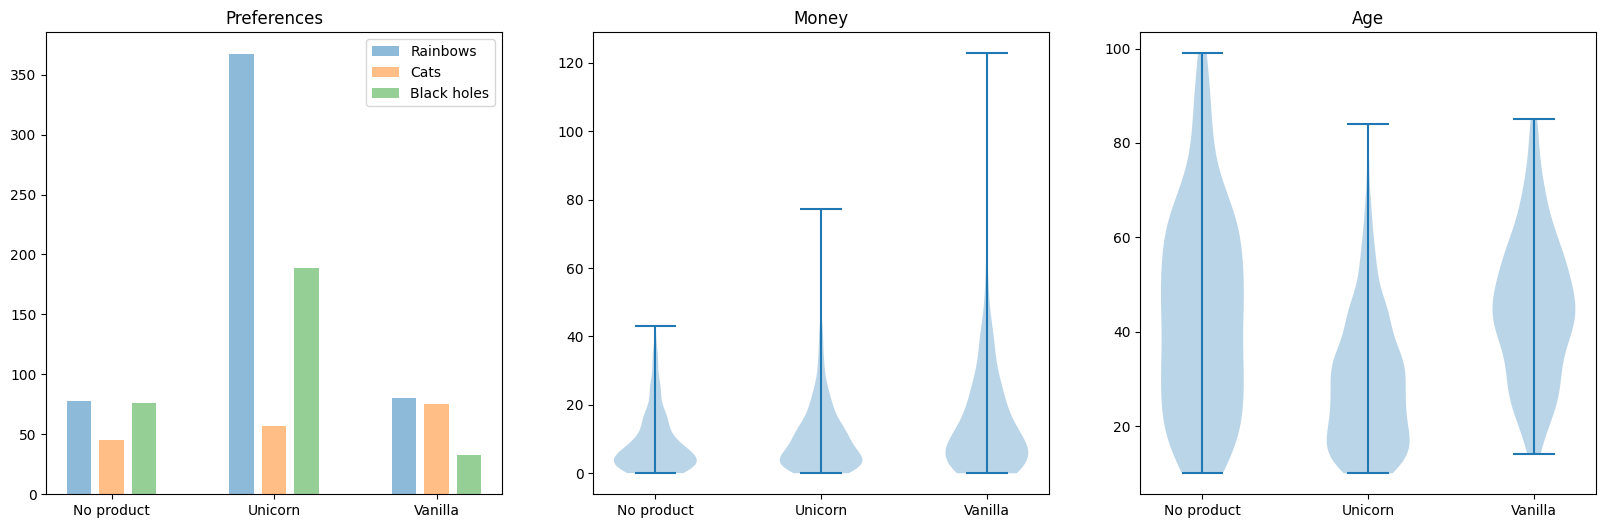

In [3]:
pd.set_option("future.no_silent_downcasting", True)

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

for i, preference in enumerate(data["preferences"].unique()):
    x = data.loc[data["preferences"] == preference, "product"].replace(
        ["No product", "Unicorn", "Vanilla"], [-1, 0, 1]
    )
    labels, counts = np.unique(x, return_counts=True)
    axs[0].bar(
            labels + 0.2 * (i - 1), counts, alpha=0.5, label=preference, width=0.15, align="center"
        )
axs[0].set_xticks([-1, 0, 1])
axs[0].set_xticklabels(["No product", "Unicorn", "Vanilla"])
axs[0].legend()
axs[0].set_title("Preferences")

axs[1].violinplot([data.loc[data["product"] == "No product", "money"],

                   data.loc[data["product"] == "Unicorn", "money"],
                   data.loc[data["product"] == "Vanilla", "money"]])
axs[1].set_xticks([1, 2, 3])
axs[1].set_xticklabels(["No product", "Unicorn", "Vanilla"])
axs[1].set_title("Money");

axs[2].violinplot([data.loc[data["product"] == "No product", "age"],

                   data.loc[data["product"] == "Unicorn", "age"],
                   data.loc[data["product"] == "Vanilla", "age"]])
axs[2].set_xticks([1, 2, 3])
axs[2].set_xticklabels(["No product", "Unicorn", "Vanilla"])
axs[2].set_title("Age");

## a)

For each of the questions 1-3, decide
- whether the answers are continuous or discrete outcomes,
- which range the outcomes could have
- to which scale of measurement (nominal, ordinal, interval, ratio) the outcomes belong to.

## b)

To infer which products new customers are likely to buy, you set up a probabilistic model.
You assume that the answers to questions 1 - 3 are conditionally independent (Naive Bayes) given $product$ and model the dependencies as follows:
$$
f(preferences, money, product) = \\
		\mathbb{P}(preferences ~\vert~ product) \cdot f_{money}(money ~\vert~ product) \cdot \mathbb{P}(product)
$$

Estimate the parameters of your categorical prior by using maximum likelihood:
$$
\mathbb{P}(product = UC) = p_{UC} \qquad \mathbb{P}(product = VC) = p_{VC} \qquad \mathbb{P}(product = NP) = p_{NP}
$$

*Hint*: The maximum likelihood estimate of the parameters for categorically distributed variables is simply the fraction of samples from a category.

In [6]:
# modeling the prior
p_product = data["product"].value_counts(normalize=True)
p_product

product
Unicorn       0.613
No product    0.199
Vanilla       0.188
Name: proportion, dtype: float64

## c)

Based on your observations in a), you decide to model the likelihoods as follows:

1. $preferences$ follows a Categorical distribution where the parameters depend on the product the customers would buy.

2. $money$ follows an exponential distribution where the parameter $\lambda_{product}$ depends on the product the customers would buy ($\eta_{product} = \eta_{UC}$, $\eta_{product} = \eta_{VC}$ or $\eta_{product} = \eta_{NP}$):
    $$
        f_{money}(m \vert product) = \begin{cases}
            \eta_{product} \cdot e^{-\eta_{product} \cdot m} & m \geq 0 \\
            0 & \text{else}
        \end{cases}
    $$


Intuitively, your model describes the profile ($preferences$, $money$) of a customer if you already know which product they would buy ($product$).
        
Using the data, derive maximum likelihood estimates for all parameters.

*Hint*: The maximum likelihood estimate of the parameters for exponentially distributed variables is the inverse of their sample mean: $\bar{x}^{-1}$.  
*Hint*: The maximum likelihood estimate of the parameters for categorically distributed variables is simply the fraction of samples from a category.

In [11]:
pi_UC = data.loc[data["product"] == "Unicorn", "preferences"].value_counts(normalize=True)
pi_VC = data.loc[data["product"] == "Vanilla", "preferences"].value_counts(normalize=True)
pi_NP = data.loc[data["product"] == "No product", "preferences"].value_counts(normalize=True)



In [8]:
eta_UC = 1 / data.loc[data["product"] == "Unicorn", "money"].mean()
eta_VC = 1 / data.loc[data["product"] == "Vanilla", "money"].mean()
eta_NP = 1 / data.loc[data["product"] == "No product", "money"].mean()

## d) + e)

You now have access to a joint density over your data:
$$
f(preferences, money, product) = \\
    \mathbb{P}(preferences ~\vert~ product) \cdot f_{money}(money ~\vert~ product) \cdot \mathbb{P}(product)
$$
	
With the fitted model, predict the (posterior) probability
$$
	\mathbb{P}(product ~\vert~ preferences, money)
$$
that the customers below buy a unicorn cookie, a vanilla-chip cookie or no cookie at all:

| Customer  | $preferences$  | $money$   |
| --------- | ------------- | ---------:|
| Anna      | Cats          | 53.10 €   |
| Ben       | Rainbows      | 2.30 €    |
| Caroline  | Black holes   | 10.25 €   |
| ???       | Rainbows      | ??        |

Helpful distributions:
- [Exponential](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.expon.html#scipy.stats.expon)

### Anna

In [12]:
money = 53.1
prefs = "Cats"

p_NP = dists.expon.pdf(money, scale=1 / eta_NP) * pi_NP[prefs] * p_product["No product"]
p_UC = dists.expon.pdf(money, scale=1 / eta_UC) * pi_UC[prefs] * p_product["Unicorn"]
p_VC = dists.expon.pdf(money, scale=1 / eta_VC) * pi_VC[prefs] * p_product["Vanilla"]
Z = p_NP + p_UC + p_VC
p_NP = p_NP / Z
p_UC = p_UC / Z
p_VC = p_VC / Z

print(p_NP, p_UC, p_VC)

0.06533432229506901 0.20357092231083815 0.7310947553940929


### Ben

### Caroline

### Unknown customer

## f) [Bonus]

You may have noticed that the data also contains information about age. What would you need to do to include this information as well?